# 自訂的輸入層及辨識層(Dense)

## 載入套件

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

## 步驟1：載入 Flower 資料

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [8]:
data_dir

WindowsPath('C:/Users/mikec/.keras/datasets/flower_photos')

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [10]:
# 資料集來源：https://www.tensorflow.org/tutorials/load_data/images

# 參數設定
batch_size = 64
img_height = 224
img_width = 224
# data_dir = './flower_photos/'

# import os
# os.makedirs(data_dir, exist_ok=True)

# 載入 Flower 訓練資料
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 載入 Flower 驗證資料
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 步驟2：進行特徵工程，將特徵縮放成(0, 1)之間

In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## 顯示 ResNet152V2 完整的模型結構

In [12]:
base_model = ResNet152V2(weights='imagenet')
print(base_model.summary())

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_blo

                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
          

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
          

In [13]:
len(base_model.layers)

566

## 步驟3：建立模型結構

In [17]:
# 預先訓練好的模型 -- ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False)
print(base_model.summary())

# 加上自訂的辨識層(Dense)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)

# 指定自訂的輸入層及辨識層(Dense)
model = Model(inputs=base_model.input, outputs=predictions)

# 模型前段不需訓練了
for layer in base_model.layers:
    layer.trainable = False

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                     

                                                                                                  
 conv2_block2_out (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, None, None,   1024       ['conv2_block2_out[0][0]']       
 ormalization)                  256)                                                              
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, None, None,   0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        256)                                                              
                                                                                                  
 conv2_blo

                                128)                             ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block2_1_relu[0][0]']    
 g2D)                           128)                                                              
          

 conv3_block4_2_relu (Activatio  (None, None, None,   0          ['conv3_block4_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block4_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block4_out (Add)         (None, None, None,   0           ['conv3_block3_out[0][0]',       
                                512)                              'conv3_block4_3_conv[0][0]']    
                                                                                                  
 conv3_block5_preact_bn (BatchN  (None, None, None,   2048       ['conv3_block4_out[0][0]']       
 ormalizat

                                                                                                  
 conv3_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block7_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block7_1_relu (Activatio  (None, None, None,   0          ['conv3_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block7_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block7_1_relu[0][0]']    
 g2D)                           128)                                                              
                                                                                                  
 conv3_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, None, None,   0          ['conv4_block1_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, None, None,   525312      ['conv4_block1_preact_relu[0][0]'
                                1024)                            ]                                
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block1_2_relu[0][0]']    
                                1024)                                                             
          

 conv4_block4_preact_relu (Acti  (None, None, None,   0          ['conv4_block4_preact_bn[0][0]'] 
 vation)                        1024)                                                             
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block4_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block4_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block6_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_blo

 vation)                        1024)                                                             
                                                                                                  
 conv4_block9_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block9_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block9_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block11_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block11_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block11_2_relu (Activati  (None, None, None,   0          ['conv4_block11_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block11_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block11_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block11_out (Add)        (None, None, None,   0           ['conv4_block10_out[0][0]',      
          

                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, None, None,   262144      ['conv4_block14_preact_relu[0][0]
                                256)                             ']                               
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block14_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block14_1_relu (Activati  (None, None, None,   0          ['conv4_block14_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      256)                                                              
                                                                                                  
 conv4_block16_2_relu (Activati  (None, None, None,   0          ['conv4_block16_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block16_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block16_out (Add)        (None, None, None,   0           ['conv4_block15_out[0][0]',      
                                1024)                             'conv4_block16_3_conv[0][0]']   
          

 conv4_block19_1_conv (Conv2D)  (None, None, None,   262144      ['conv4_block19_preact_relu[0][0]
                                256)                             ']                               
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block19_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block19_1_relu (Activati  (None, None, None,   0          ['conv4_block19_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block19_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block19_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block21_2_relu (Activati  (None, None, None,   0          ['conv4_block21_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_out (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_blo

                                256)                             ']                               
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block24_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block24_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block24_1_relu[0][0]']   
 ng2D)                          256)                                                              
          

 conv4_block26_2_relu (Activati  (None, None, None,   0          ['conv4_block26_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block26_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block26_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block26_out (Add)        (None, None, None,   0           ['conv4_block25_out[0][0]',      
                                1024)                             'conv4_block26_3_conv[0][0]']   
                                                                                                  
 conv4_block27_preact_bn (Batch  (None, None, None,   4096       ['conv4_block26_out[0][0]']      
 Normaliza

                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block29_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block29_1_relu (Activati  (None, None, None,   0          ['conv4_block29_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block29_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block29_1_relu[0][0]']   
 ng2D)                          256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block31_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block31_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block31_out (Add)        (None, None, None,   0           ['conv4_block30_out[0][0]',      
                                1024)                             'conv4_block31_3_conv[0][0]']   
                                                                                                  
 conv4_block32_preact_bn (Batch  (None, None, None,   4096       ['conv4_block31_out[0][0]']      
 Normalization)                 1024)                                                             
          

 conv4_block34_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block34_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block34_1_relu (Activati  (None, None, None,   0          ['conv4_block34_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block34_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block34_1_relu[0][0]']   
 ng2D)                          256)                                                              
                                                                                                  
 conv4_block34_2_conv (Conv2D)  (None, None, None,   589824      ['conv4_block34_2_pad[0][0]']    
          

                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, None, None,   0          ['conv4_block35_out[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block36_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block36_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block36_out (Add)        (None, None, None,   0           ['max_pooling2d_8[0][0]',        
                                1024)                             'conv4_block36_3_conv[0][0]']   
                                                                                                  
 conv5_blo

 vation)                        2048)                                                             
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   1048576     ['conv5_block3_preact_relu[0][0]'
                                512)                             ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
          

In [18]:
len(base_model.layers)

564

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_out (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, None, None,   1024       ['conv2_block2_out[0][0]']       
 ormalization)                  256)                                                              
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, None, None,   0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        256)                                                              
                                                                                                  
 conv2_blo

                                128)                             ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block2_1_relu[0][0]']    
 g2D)                           128)                                                              
          

 conv3_block4_2_relu (Activatio  (None, None, None,   0          ['conv3_block4_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block4_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block4_out (Add)         (None, None, None,   0           ['conv3_block3_out[0][0]',       
                                512)                              'conv3_block4_3_conv[0][0]']    
                                                                                                  
 conv3_block5_preact_bn (BatchN  (None, None, None,   2048       ['conv3_block4_out[0][0]']       
 ormalizat

                                                                                                  
 conv3_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block7_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block7_1_relu (Activatio  (None, None, None,   0          ['conv3_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block7_2_pad (ZeroPaddin  (None, None, None,   0          ['conv3_block7_1_relu[0][0]']    
 g2D)                           128)                                                              
                                                                                                  
 conv3_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, None, None,   0          ['conv4_block1_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, None, None,   525312      ['conv4_block1_preact_relu[0][0]'
                                1024)                            ]                                
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block1_2_relu[0][0]']    
                                1024)                                                             
          

 conv4_block4_preact_relu (Acti  (None, None, None,   0          ['conv4_block4_preact_bn[0][0]'] 
 vation)                        1024)                                                             
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block4_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block4_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block6_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_blo

 vation)                        1024)                                                             
                                                                                                  
 conv4_block9_1_conv (Conv2D)   (None, None, None,   262144      ['conv4_block9_preact_relu[0][0]'
                                256)                             ]                                
                                                                                                  
 conv4_block9_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block11_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block11_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block11_2_relu (Activati  (None, None, None,   0          ['conv4_block11_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block11_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block11_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block11_out (Add)        (None, None, None,   0           ['conv4_block10_out[0][0]',      
          

                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, None, None,   262144      ['conv4_block14_preact_relu[0][0]
                                256)                             ']                               
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block14_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block14_1_relu (Activati  (None, None, None,   0          ['conv4_block14_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      256)                                                              
                                                                                                  
 conv4_block16_2_relu (Activati  (None, None, None,   0          ['conv4_block16_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block16_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block16_out (Add)        (None, None, None,   0           ['conv4_block15_out[0][0]',      
                                1024)                             'conv4_block16_3_conv[0][0]']   
          

 conv4_block19_1_conv (Conv2D)  (None, None, None,   262144      ['conv4_block19_preact_relu[0][0]
                                256)                             ']                               
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block19_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block19_1_relu (Activati  (None, None, None,   0          ['conv4_block19_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block19_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block19_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block21_2_relu (Activati  (None, None, None,   0          ['conv4_block21_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_out (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_blo

                                256)                             ']                               
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block24_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block24_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block24_1_relu[0][0]']   
 ng2D)                          256)                                                              
          

 conv4_block26_2_relu (Activati  (None, None, None,   0          ['conv4_block26_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block26_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block26_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block26_out (Add)        (None, None, None,   0           ['conv4_block25_out[0][0]',      
                                1024)                             'conv4_block26_3_conv[0][0]']   
                                                                                                  
 conv4_block27_preact_bn (Batch  (None, None, None,   4096       ['conv4_block26_out[0][0]']      
 Normaliza

                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block29_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block29_1_relu (Activati  (None, None, None,   0          ['conv4_block29_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block29_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block29_1_relu[0][0]']   
 ng2D)                          256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block31_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block31_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block31_out (Add)        (None, None, None,   0           ['conv4_block30_out[0][0]',      
                                1024)                             'conv4_block31_3_conv[0][0]']   
                                                                                                  
 conv4_block32_preact_bn (Batch  (None, None, None,   4096       ['conv4_block31_out[0][0]']      
 Normalization)                 1024)                                                             
          

 conv4_block34_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block34_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block34_1_relu (Activati  (None, None, None,   0          ['conv4_block34_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block34_2_pad (ZeroPaddi  (None, None, None,   0          ['conv4_block34_1_relu[0][0]']   
 ng2D)                          256)                                                              
                                                                                                  
 conv4_block34_2_conv (Conv2D)  (None, None, None,   589824      ['conv4_block34_2_pad[0][0]']    
          

                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, None, None,   0          ['conv4_block35_out[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block36_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block36_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block36_out (Add)        (None, None, None,   0           ['max_pooling2d_8[0][0]',        
                                1024)                             'conv4_block36_3_conv[0][0]']   
                                                                                                  
 conv5_blo

 vation)                        2048)                                                             
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   1048576     ['conv5_block3_preact_relu[0][0]'
                                512)                             ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
          

## 步驟5：模型訓練

In [20]:
# 設定快取(cache)、prefetch，以增進訓練效率
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 模型訓練
history = model.fit(normalized_ds, validation_data = normalized_val_ds, epochs=5)

Epoch 1/5
46/46 [==============================] - 70s 1s/step - loss: 0.7945 - accuracy: 0.7207 - val_loss: 0.4677 - val_accuracy: 0.8529
Epoch 2/5
46/46 [==============================] - 52s 1s/step - loss: 0.4048 - accuracy: 0.8658 - val_loss: 0.3863 - val_accuracy: 0.8692
Epoch 3/5
46/46 [==============================] - 52s 1s/step - loss: 0.3047 - accuracy: 0.9009 - val_loss: 0.3592 - val_accuracy: 0.8706
Epoch 4/5
46/46 [==============================] - 52s 1s/step - loss: 0.2473 - accuracy: 0.9230 - val_loss: 0.3481 - val_accuracy: 0.8760
Epoch 5/5
46/46 [==============================] - 53s 1s/step - loss: 0.2076 - accuracy: 0.9356 - val_loss: 0.3444 - val_accuracy: 0.8842


## 步驟6：繪製訓練時準確率/損失函數的變化

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

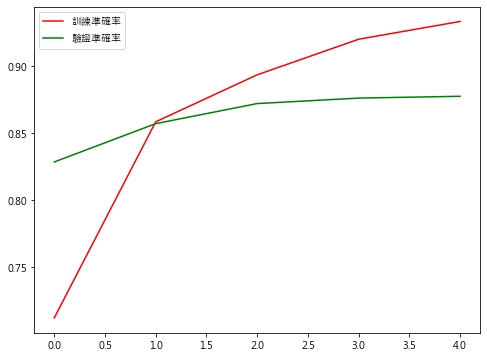

In [36]:
# 對訓練過程的準確率繪圖
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.xlabel('Epoch')
plt.ylabel('準確率')
plt.legend()

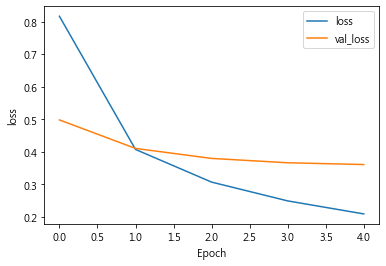

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='訓練損失')
plt.plot(history.history['val_loss'], label = '驗證損失')
plt.xlabel('Epoch')
plt.ylabel('損失')
plt.legend()

## 步驟7：預測

In [26]:
# 顯示辨識的類別
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [27]:
# 任選一張圖片，例如玫瑰
img_path = './images_test/rose.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一維，變成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 預測
preds = model.predict(x)

# 顯示預測結果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'預測機率(%)：{y_pred}')
print(f'預測類別：{class_names[np.argmax(preds)]}')

預測機率(%)：[0.1, 0.0, 99.76, 0.05, 0.08]
預測類別：roses


In [28]:
# 任選一張圖片，例如雛菊
img_path = './images_test/daisy2.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一維，變成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 預測
preds = model.predict(x)

# 顯示預測結果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'預測機率(%)：{y_pred}')
print(f'預測類別：{class_names[np.argmax(preds)]}')

預測機率(%)：[99.92, 0.02, 0.0, 0.06, 0.0]
預測類別：daisy
